In [1]:
import os
import torch
import numpy as np
import pandas as pd
import nltk
import random
from collections import Counter
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### Load Data and Data Preprocessing

In [2]:
# specify date type and device type
dtype = torch.float
device = torch.device("cpu")

In [4]:
# initial peek of the training set
data = pd.read_csv("./hw2_data/snli_train.tsv", sep='\t', header = 0)
data.head()

,sentence1,sentence2,label
0,A young girl in a pink shirt sitting on a dock...,A young girl watching the sunset over the water .,neutral
1,A woman is smiling while the man next to her i...,Two people are next to each other .,entailment
2,"Across the river , you can see a large building .",The large building is full of apartments and t...,neutral
3,a man in white shorts and a black shirt is par...,A man is riding a jetski on the ocean .,contradiction
4,Four black dogs run together on bright green g...,Four dogs are preparing to be launched into sp...,contradiction


In [5]:
# initial peek of the validation set
vali = pd.read_csv("./hw2_data/snli_val.tsv", sep='\t', header = 0)
vali.head()

,sentence1,sentence2,label
0,"Three women on a stage , one wearing red shoes...",There are two women standing on the stage,contradiction
1,"Four people sit on a subway two read books , o...","Multiple people are on a subway together , wit...",entailment
2,bicycles stationed while a group of people soc...,People get together near a stand of bicycles .,entailment
3,Man in overalls with two horses .,a man in overalls with two horses,entailment
4,Man observes a wavelength given off by an elec...,The man is examining what wavelength is given ...,entailment


In [6]:
# get shape of the data
data.shape, vali.shape

((100000, 3), (1000, 3))

In [7]:
# check for any missing values
data.isnull().sum(axis = 0)

sentence1    0
sentence2    0
label        0
dtype: int64

In [8]:
# check for any missing values
vali.isnull().sum(axis = 0)

sentence1    0
sentence2    0
label        0
dtype: int64

In [9]:
label_idx = {"entailment": 0, "contradiction": 1, "neutral": 2}

In [10]:
def load_data(PATH_TO_FILE):
    data = pd.read_csv(PATH_TO_FILE, sep='\t', header=0)
    s1_text = []
    s2_text = []
    label = []
    for idx, row in data.iterrows():
        s1 = row['sentence1'].lower()
        s2 = row['sentence2'].lower()
        label.append(label_idx[row['label'].lower()])
        s1_text.append(s1.split())
        s2_text.append(s2.split())
    return s1_text, s2_text, label

In [12]:
train_s1_text, train_s2_text, train_label = load_data("./hw2_data/snli_train.tsv")

In [ ]:
val_s1_text, val_s2_text, val_label = load_data("./hw2_data/snli_val.tsv")

In [13]:
def load_data(PATH_TO_FILE):
    data = pd.read_csv(PATH_TO_FILE, sep='\t', header=0)
    s1_text = []
    s2_text = []
    label = []
    for idx, row in data.iterrows():
        s1 = row['sentence1'].lower()
        s2 = row['sentence2'].lower()
        label.append(label_idx[row['label'].lower()])
        s1_text.append(s1.split())
        s2_text.append(s2.split())
    return s1_text, s2_text, label

In [14]:
# print size of the training set
print(len(train_s1_text), len(train_s2_text), len(train_label))

100000 100000 100000


In [15]:
# print size of the validation set
print(len(val_s1_text), len(val_s2_text), len(val_label))

1000 1000 1000


In [16]:
# check all labels are numerical by now
all(type(item)==int for item in train_label)
all(type(item)==int for item in val_label)

True

In [17]:
PAD_IDX = 0
UNK_IDX = 1

In [18]:
def get_num_unique(d):
    unique = set()
    for l in d:
        for w in l:
            unique.add(w)
    return len(unique)

In [19]:
TRAIN_S1_VOCAB_SIZE = get_num_unique(train_s1_text)
TRAIN_S2_VOCAB_SIZE = get_num_unique(train_s2_text)
TRAIN_VOCAB_SIZE = get_num_unique(train_s1_text + train_s2_text)
print(TRAIN_S1_VOCAB_SIZE, TRAIN_S2_VOCAB_SIZE, TRAIN_VOCAB_SIZE)

15189 15699 21023


In [20]:
all_train_s1_tokens = [token for sublist in train_s1_text for token in sublist]
all_train_s2_tokens = [token for sublist in train_s2_text for token in sublist]
all_train_tokens = all_train_s1_tokens + all_train_s2_tokens
print(len(all_train_s1_tokens), len(all_train_s2_tokens), len(all_train_tokens))

1403863 824202 2228065


In [21]:
def build_vocab(all_tokens, MAX_VOCAB_SIZE):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(MAX_VOCAB_SIZE))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab))))
    id2token = ['PAD', 'UNK'] + id2token
    token2id['PAD'] = PAD_IDX
    token2id['UNK'] = UNK_IDX
    return token2id, id2token

In [22]:
token2id, id2token = build_vocab(all_train_tokens, TRAIN_VOCAB_SIZE)

In [23]:
# ADDED 'PAD' and 'UNK' into our vocabulary
TRAIN_VOCAB_SIZE += 2

In [24]:
# Lets check the dictionary by loading random token from it

random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 2891 ; token classic
Token classic; token id 2891


In [25]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

In [26]:
train_s1_indices = token2index_dataset(train_s1_text)
train_s2_indices = token2index_dataset(train_s2_text)
val_s1_indices = token2index_dataset(val_s1_text)
val_s2_indices = token2index_dataset(val_s2_text)

In [27]:
# double checking
print ("Sentence 1 train dataset size is {}".format(len(train_s1_indices)))
print ("Sentence 2 train dataset size is {}".format(len(train_s2_indices)))
print ("Sentence 1 val dataset size is {}".format(len(val_s1_indices)))
print ("Sentence 2 val dataset size is {}".format(len(val_s2_indices)))

Sentence 1 train dataset size is 100000
Sentence 2 train dataset size is 100000
Sentence 1 val dataset size is 1000
Sentence 2 val dataset size is 1000


In [28]:
# get maximum sentence length
S1_MAX_SENTENCE_LENGTH = max([len(sublist) for sublist in train_s1_text])
S2_MAX_SENTENCE_LENGTH = max([len(sublist) for sublist in train_s2_text])
MAX_SENTENCE_LENGTH = max(S1_MAX_SENTENCE_LENGTH, S2_MAX_SENTENCE_LENGTH)
print(S1_MAX_SENTENCE_LENGTH, S2_MAX_SENTENCE_LENGTH, MAX_SENTENCE_LENGTH)

82 41 82


In [29]:
TRAIN_VOCAB_SIZE == len(token2id) == len(id2token)

True

### Get Pretrained Word Vectors

In [38]:
# # load fasttext pretrained word vectors
# with open('./crawl-300d-2M.vec') as f:
#     embedding_matrix = np.zeros((TRAIN_VOCAB_SIZE, 300))
#     for i, line in enumerate(f):
#         s = line.split()
#         w = s[0].lower()
#         v = np.asarray(s[1:])
#         if w in token2id:
#             embedding_matrix[token2id[w], :] = v
# #         loaded_embeddings[i, :] = np.asarray(s[1:])

In [39]:
# save embedding_matrix for future use
#np.save('embedding_matrix.npy', embedding_matrix)

In [30]:
# load saved embedding_matrix
embedding_matrix = np.load('embedding_matrix.npy')

In [31]:
# print shape of the embedding matrix
embedding_matrix.shape

(21025, 300)

### Data Generator

In [32]:
class SnilDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, s1_data_list, s2_data_list, target_list, token2id):
        """
        @param data_list: list of tokens
        @param target_list: list of targets

        """
        self.s1_data_list, self.s2_data_list, self.target_list = s1_data_list, s2_data_list, target_list
        assert(len(self.s1_data_list) == len(self.target_list))
        assert(len(self.s2_data_list) == len(self.target_list))
        self.token2id = token2id

    def __len__(self):
        return len(self.s1_data_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        s1_token_idx = self.s1_data_list[key][:MAX_SENTENCE_LENGTH]
        s2_token_idx = self.s2_data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [s1_token_idx, s2_token_idx, len(s1_token_idx), len(s2_token_idx), label]

In [33]:
def collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    s1_data_list = []
    s2_data_list = []
    label_list = []
    s1_length_list = []
    s2_length_list = []

    for datum in batch:
        label_list.append(datum[4])
        s1_length_list.append(datum[2])
        s2_length_list.append(datum[3])
    for datum in batch:
        s1_padded_vec = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])),
                                mode="constant", constant_values=0)
        s1_data_list.append(s1_padded_vec)
        s2_padded_vec = np.pad(np.array(datum[1]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])),
                                mode="constant", constant_values=0)
        s2_data_list.append(s2_padded_vec)
    return [torch.from_numpy(np.array(s1_data_list)), torch.from_numpy(np.array(s2_data_list)), torch.LongTensor(s1_length_list), torch.LongTensor(s2_length_list), torch.LongTensor(label_list)]

In [34]:
BATCH_SIZE = 128
train_dataset = SnilDataset(train_s1_indices, train_s2_indices, train_label, token2id)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=collate_func,
                                           shuffle=False)

In [35]:
val_dataset = SnilDataset(train_s1_indices, train_s2_indices, train_label, token2id)
val_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=collate_func,
                                           shuffle=False)

### RNN

In [188]:
class TwoSentencesRNN(nn.Module):
    """Encapsulates the implementation of RNN-based two sentence relation prediction model"""

    def __init__(self, embedding_matrix, num_classes, seq_len):
        
        super(TwoSentencesRNN, self).__init__()

        # Build embedding layer
        vocab_size = embedding_matrix.shape[0]
        embedding_dim = embedding_matrix.shape[1]
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        self.embed.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embed.requires_grad = False
        
        # Build RNN
        rnn_hidden_size = 128
#         rnn_hidden_size = 256
#         rnn_hidden_size = 64
        
        rnn_num_layers = 1
        self.gru = nn.GRU(embedding_dim, rnn_hidden_size, rnn_num_layers, batch_first=True)
        self.h0 = torch.autograd.Variable(torch.randn(rnn_num_layers, rnn_hidden_size, rnn_hidden_size))
#         self.h0 = torch.autograd.Variable(torch.randn(rnn_num_layers, rnn_hidden_size//2, rnn_hidden_size))
#         self.h0 = torch.autograd.Variable(torch.randn(rnn_num_layers, rnn_hidden_size * 2, rnn_hidden_size))

        # Build classification head
        cls_hidden_size = 128
#         for concate
#         self.cls_net = nn.Sequential(nn.Linear(rnn_hidden_size * 2, cls_hidden_size), nn.Linear(cls_hidden_size, num_classes))
#         for multi
        self.cls_net = nn.Sequential(nn.Linear(rnn_hidden_size, cls_hidden_size), nn.Linear(cls_hidden_size, num_classes))


    def forward(self, sent1, sent2, sent1_len, sent2_len):
        e1, e2 = self.embed(sent1), self.embed(sent2)

        outs1, _ = self.gru(e1, self.h0)
        outs2, _ = self.gru(e2, self.h0)

        # Get the last output
        batch_size = e1.size()[0]
        f1 = outs1[torch.arange(batch_size, out=torch.LongTensor()), sent1_len - 1]
        f2 = outs2[torch.arange(batch_size, out=torch.LongTensor()), sent2_len - 1]
        print(outs1.size(), outs2.size())
        print(f1.size(), f2.size())
        
        # concatenation
#         concat_features = torch.cat([f1, f2], 1)
        
        # element-wise multiplication
        concat_features = torch.mul(f1, f2)

        logits = self.cls_net(concat_features)

        return logits

In [189]:
def evaluate(model, loss_func, sent1, sent2, sent1_len, sent2_len, labels):
    logits = model(sent1, sent2, sent1_len, sent2_len)
    loss = loss_func(logits, labels)
    _, pred = torch.max(logits, 1)
    acc = (labels == pred).sum()
    pred_value = pred.cpu().data
    loss_value = loss.cpu().data[0]
    acc_value = acc.cpu().data.numpy() / labels.size()[0]
    return loss, float(loss_value), float(acc_value)

best_val_acc = 0
train_losses, train_accs, val_losses, val_accs = [], [], [], []

def train(model, num_epochs, learning_rate, train_loader, val_loader, load_from_path, save_to_path, best_val_acc, train_losses, train_accs, val_losses, val_accs):

    # Define loss function
    ce_loss = nn.CrossEntropyLoss()
    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
#     best_val_acc = 0
#     train_losses, train_accs, val_losses, val_accs = [], [], [], []

    # Load model
    if load_from_path is not None:
        checkpoint = torch.load(load_from_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_val_acc = checkpoint['best_val_acc']
        train_losses = checkpoint['train_losses']
        train_accs = checkpoint['train_accs']
        val_losses = checkpoint['val_losses']
        val_accs = checkpoint['val_accs']

    for epoch in range(num_epochs):
        for i, (sent1, sent2, sent1_len, sent2_len, labels) in enumerate(train_loader):
            # Flag training mode for the model
            model.train()
            
            # Clear all accumulated gradients
            optimizer.zero_grad()
            
            loss, train_loss_value, train_acc_value = evaluate(model, ce_loss, sent1, sent2, sent1_len, sent2_len, labels)

            # Backprop from loss
            loss.backward()
            
            # Update parameters
            optimizer.step()
            
            # Validation
            for val_sent1, val_sent2, val_sent1_len, val_sent2_len, val_labels in val_loader:
                model.eval()
                _, val_loss_value, val_acc_value = evaluate(model, ce_loss, val_sent1, val_sent2, val_sent1_len, val_sent2_len, val_labels)
                break

            train_losses.append(train_loss_value)
            train_accs.append(train_acc_value)
            val_losses.append(val_loss_value)
            val_accs.append(val_acc_value)

            if i % 10 == 0:
                if val_acc_value > best_val_acc and save_to_path is not None:
                    best_val_acc = val_acc_value
                    # Save model
                    save_dict = {
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'best_val_acc': best_val_acc,
                        'train_losses': train_losses,
                        'train_accs': train_accs,
                        'val_losses': val_losses,
                        'val_accs': val_accs
                    }
                    torch.save(save_dict, save_to_path)
                print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Train Acc: {}, Val Loss: {}, Val Acc: {}'.format(epoch+1, num_epochs, i+1, len(train_loader), train_loss_value, train_acc_value, val_loss_value, val_acc_value))


In [75]:
model = TwoSentencesRNN(embedding_matrix, 3, MAX_SENTENCE_LENGTH)
load_from_path = None 
save_to_path = "./rnn_concate_128.pkl"
train(model, 1, 1e-2, train_loader, val_loader, load_from_path, save_to_path, best_val_acc, train_losses, train_accs, val_losses, val_accs)

/Users/wu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Epoch: [0/1], Step: 0, Train Loss: 1.1025400161743164, Train Acc: 0.328125, Val Loss: 1.250766396522522, Val Acc: 0.3515625
Epoch: [0/1], Step: 10, Train Loss: 1.0999537706375122, Train Acc: 0.421875, Val Loss: 1.0636831521987915, Val Acc: 0.421875
Epoch: [0/1], Step: 20, Train Loss: 1.0238621234893799, Train Acc: 0.484375, Val Loss: 0.8500363230705261, Val Acc: 0.6484375
Epoch: [0/1], Step: 30, Train Loss: 0.9575279951095581, Train Acc: 0.4921875, Val Loss: 0.8430554866790771, Val Acc: 0.6484375
Epoch: [0/1], Step: 40, Train Loss: 1.021957516670227, Train Acc: 0.5, Val Loss: 0.8264278173446655, Val Acc: 0.625
Epoch: [0/1], Step: 50, Train Loss: 0.9211183190345764, Train Acc: 0.578125, Val Loss: 0.8354662656784058, Val Acc: 0.703125
Epoch: [0/1], Step: 60, Train Loss: 1.0133389234542847, Train Acc: 0.5390625, Val Loss: 0.8332809805870056, Val Acc: 0.703125
Epoch: [0/1], Step: 70, Train Loss: 0.9402948617935181, Train Acc: 0.515625, Val Loss: 0.8327350616455078, Val Acc: 0.6953125
Epoch

Epoch: [0/1], Step: 660, Train Loss: 0.8704209327697754, Train Acc: 0.625, Val Loss: 0.7882748246192932, Val Acc: 0.65625
Epoch: [0/1], Step: 670, Train Loss: 0.9968437552452087, Train Acc: 0.5078125, Val Loss: 0.7544188499450684, Val Acc: 0.734375
Epoch: [0/1], Step: 680, Train Loss: 0.9228274822235107, Train Acc: 0.546875, Val Loss: 0.7206899523735046, Val Acc: 0.7265625
Epoch: [0/1], Step: 690, Train Loss: 0.9461703300476074, Train Acc: 0.5390625, Val Loss: 0.7985314726829529, Val Acc: 0.65625
Epoch: [0/1], Step: 700, Train Loss: 0.9770779013633728, Train Acc: 0.5703125, Val Loss: 0.7643206715583801, Val Acc: 0.7265625
Epoch: [0/1], Step: 710, Train Loss: 0.969016969203949, Train Acc: 0.53125, Val Loss: 0.7294343113899231, Val Acc: 0.7109375
Epoch: [0/1], Step: 720, Train Loss: 0.875776469707489, Train Acc: 0.6015625, Val Loss: 0.7201740145683289, Val Acc: 0.703125
Epoch: [0/1], Step: 730, Train Loss: 0.8886897563934326, Train Acc: 0.59375, Val Loss: 0.7437008023262024, Val Acc: 0.7

RuntimeError: Expected hidden size (1, 32, 128), got (1, 128, 128)

In [127]:
model = TwoSentencesRNN(embedding_matrix, 3, MAX_SENTENCE_LENGTH)
load_from_path = None
save_to_path = "./rnn_concate_256.pkl"
train(model, 1, 1e-2, train_loader, val_loader, load_from_path, save_to_path, best_val_acc, train_losses, train_accs, val_losses, val_accs)

/Users/wu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Epoch: [1/1], Step: [1/782], Train Loss: 1.0977369546890259, Train Acc: 0.3515625, Val Loss: 1.4859557151794434, Val Acc: 0.3359375
Epoch: [1/1], Step: [11/782], Train Loss: 1.3033210039138794, Train Acc: 0.3203125, Val Loss: 1.1599773168563843, Val Acc: 0.3203125
Epoch: [1/1], Step: [21/782], Train Loss: 1.1508828401565552, Train Acc: 0.296875, Val Loss: 1.0431727170944214, Val Acc: 0.3671875
Epoch: [1/1], Step: [31/782], Train Loss: 1.012952208518982, Train Acc: 0.4140625, Val Loss: 0.9414364695549011, Val Acc: 0.515625
Epoch: [1/1], Step: [41/782], Train Loss: 1.0330867767333984, Train Acc: 0.5, Val Loss: 0.9771208763122559, Val Acc: 0.5078125
Epoch: [1/1], Step: [51/782], Train Loss: 1.0127274990081787, Train Acc: 0.4375, Val Loss: 0.8768258094787598, Val Acc: 0.703125
Epoch: [1/1], Step: [61/782], Train Loss: 1.053018569946289, Train Acc: 0.5078125, Val Loss: 0.8316638469696045, Val Acc: 0.7265625
Epoch: [1/1], Step: [71/782], Train Loss: 0.9535844326019287, Train Acc: 0.5, Val Lo

Epoch: [1/1], Step: [631/782], Train Loss: 1.104061245918274, Train Acc: 0.515625, Val Loss: 0.898739218711853, Val Acc: 0.6015625
Epoch: [1/1], Step: [641/782], Train Loss: 0.8942179679870605, Train Acc: 0.578125, Val Loss: 0.825308084487915, Val Acc: 0.625
Epoch: [1/1], Step: [651/782], Train Loss: 1.0482287406921387, Train Acc: 0.5625, Val Loss: 1.0081586837768555, Val Acc: 0.4921875
Epoch: [1/1], Step: [661/782], Train Loss: 0.9536917209625244, Train Acc: 0.5859375, Val Loss: 0.9284330606460571, Val Acc: 0.609375
Epoch: [1/1], Step: [671/782], Train Loss: 1.0861860513687134, Train Acc: 0.5, Val Loss: 0.8655147552490234, Val Acc: 0.5546875
Epoch: [1/1], Step: [681/782], Train Loss: 1.0199133157730103, Train Acc: 0.53125, Val Loss: 0.8355879187583923, Val Acc: 0.609375
Epoch: [1/1], Step: [691/782], Train Loss: 0.9224233031272888, Train Acc: 0.5234375, Val Loss: 0.8235981464385986, Val Acc: 0.609375
Epoch: [1/1], Step: [701/782], Train Loss: 1.034873127937317, Train Acc: 0.5, Val Los

RuntimeError: Expected hidden size (1, 32, 256), got (1, 128, 256)

In [138]:
model = TwoSentencesRNN(embedding_matrix, 3, MAX_SENTENCE_LENGTH)
load_from_path = None
save_to_path = "./rnn_concate_64.pkl"
train(model, 1, 1e-2, train_loader, val_loader, load_from_path, save_to_path, best_val_acc, train_losses, train_accs, val_losses, val_accs)

/Users/wu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Epoch: [1/1], Step: [1/782], Train Loss: 1.1043460369110107, Train Acc: 0.34375, Val Loss: 1.1027675867080688, Val Acc: 0.3671875
Epoch: [1/1], Step: [11/782], Train Loss: 1.0607693195343018, Train Acc: 0.4765625, Val Loss: 0.9516038298606873, Val Acc: 0.6484375
Epoch: [1/1], Step: [21/782], Train Loss: 1.022309422492981, Train Acc: 0.53125, Val Loss: 0.7498926520347595, Val Acc: 0.7109375
Epoch: [1/1], Step: [31/782], Train Loss: 0.9656860828399658, Train Acc: 0.53125, Val Loss: 0.8673946261405945, Val Acc: 0.59375
Epoch: [1/1], Step: [41/782], Train Loss: 1.0290248394012451, Train Acc: 0.4765625, Val Loss: 0.85332190990448, Val Acc: 0.640625
Epoch: [1/1], Step: [51/782], Train Loss: 0.9426600337028503, Train Acc: 0.578125, Val Loss: 0.8461145162582397, Val Acc: 0.6328125
Epoch: [1/1], Step: [61/782], Train Loss: 0.9909589886665344, Train Acc: 0.546875, Val Loss: 0.8118904829025269, Val Acc: 0.6875
Epoch: [1/1], Step: [71/782], Train Loss: 0.905884325504303, Train Acc: 0.578125, Val L

Epoch: [1/1], Step: [631/782], Train Loss: 0.862338125705719, Train Acc: 0.59375, Val Loss: 0.8395014405250549, Val Acc: 0.578125
Epoch: [1/1], Step: [641/782], Train Loss: 0.823528528213501, Train Acc: 0.6796875, Val Loss: 0.7663270831108093, Val Acc: 0.65625
Epoch: [1/1], Step: [651/782], Train Loss: 0.9282271265983582, Train Acc: 0.59375, Val Loss: 0.790145218372345, Val Acc: 0.6484375
Epoch: [1/1], Step: [661/782], Train Loss: 0.8168835639953613, Train Acc: 0.6171875, Val Loss: 0.7399991750717163, Val Acc: 0.625
Epoch: [1/1], Step: [671/782], Train Loss: 0.9455671310424805, Train Acc: 0.5625, Val Loss: 0.7686813473701477, Val Acc: 0.6953125
Epoch: [1/1], Step: [681/782], Train Loss: 0.9075796008110046, Train Acc: 0.5703125, Val Loss: 0.8059996962547302, Val Acc: 0.6640625
Epoch: [1/1], Step: [691/782], Train Loss: 0.8703347444534302, Train Acc: 0.6171875, Val Loss: 0.7854459285736084, Val Acc: 0.671875
Epoch: [1/1], Step: [701/782], Train Loss: 0.9817054271697998, Train Acc: 0.5390

RuntimeError: Expected hidden size (1, 32, 64), got (1, 128, 64)

In [176]:
model = TwoSentencesRNN(embedding_matrix, 3, MAX_SENTENCE_LENGTH)
load_from_path = None
save_to_path = "./rnn_multi_128.pkl"
train(model, 1, 1e-2, train_loader, val_loader, load_from_path, save_to_path, best_val_acc, train_losses, train_accs, val_losses, val_accs)

/Users/wu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Epoch: [1/1], Step: [1/782], Train Loss: 1.1008150577545166, Train Acc: 0.296875, Val Loss: 1.0766810178756714, Val Acc: 0.3515625
Epoch: [1/1], Step: [11/782], Train Loss: 1.0887055397033691, Train Acc: 0.3359375, Val Loss: 1.0874011516571045, Val Acc: 0.4453125
Epoch: [1/1], Step: [21/782], Train Loss: 1.091387391090393, Train Acc: 0.375, Val Loss: 1.0708876848220825, Val Acc: 0.3671875
Epoch: [1/1], Step: [31/782], Train Loss: 1.0558542013168335, Train Acc: 0.4375, Val Loss: 1.0252761840820312, Val Acc: 0.5
Epoch: [1/1], Step: [41/782], Train Loss: 1.0380358695983887, Train Acc: 0.4921875, Val Loss: 1.0295380353927612, Val Acc: 0.4765625
Epoch: [1/1], Step: [51/782], Train Loss: 1.045975685119629, Train Acc: 0.453125, Val Loss: 0.9827659130096436, Val Acc: 0.4765625
Epoch: [1/1], Step: [61/782], Train Loss: 1.054985523223877, Train Acc: 0.4140625, Val Loss: 1.0061341524124146, Val Acc: 0.546875
Epoch: [1/1], Step: [71/782], Train Loss: 1.0127732753753662, Train Acc: 0.4609375, Val L

Epoch: [1/1], Step: [631/782], Train Loss: 0.8719843626022339, Train Acc: 0.578125, Val Loss: 0.8722155690193176, Val Acc: 0.640625
Epoch: [1/1], Step: [641/782], Train Loss: 0.8552579879760742, Train Acc: 0.6171875, Val Loss: 0.8756563067436218, Val Acc: 0.609375
Epoch: [1/1], Step: [651/782], Train Loss: 0.8712065815925598, Train Acc: 0.5703125, Val Loss: 0.853718638420105, Val Acc: 0.578125
Epoch: [1/1], Step: [661/782], Train Loss: 0.9264711141586304, Train Acc: 0.5625, Val Loss: 0.7912349700927734, Val Acc: 0.625
Epoch: [1/1], Step: [671/782], Train Loss: 0.9635459780693054, Train Acc: 0.5703125, Val Loss: 0.8394873142242432, Val Acc: 0.6484375
Epoch: [1/1], Step: [681/782], Train Loss: 0.9012739658355713, Train Acc: 0.6328125, Val Loss: 0.7923983931541443, Val Acc: 0.625
Epoch: [1/1], Step: [691/782], Train Loss: 0.8475043773651123, Train Acc: 0.625, Val Loss: 0.8429325819015503, Val Acc: 0.671875
Epoch: [1/1], Step: [701/782], Train Loss: 0.863299548625946, Train Acc: 0.6015625,

RuntimeError: Expected hidden size (1, 32, 128), got (1, 128, 128)

In [190]:
model = TwoSentencesRNN(embedding_matrix, 3, MAX_SENTENCE_LENGTH)
load_from_path = None
save_to_path = "./test"
train(model, 1, 1e-2, train_loader, val_loader, load_from_path, save_to_path, best_val_acc, train_losses, train_accs, val_losses, val_accs)

torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])


/Users/wu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
Epoch: [1/1], Step: [1/782], Train Loss: 1.0981090068817139, Train Acc: 0.296875, Val Loss: 1.0722079277038574, Val Acc: 0.53125
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 

torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
Epoch: [1/1], Step: [41/782], Train Loss: 1.0868630409240723, Train Acc: 0.4453125, Val Loss: 1.0047675371170044, Val Acc: 0.515625
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([12

torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
Epoch: [1/1], Step: [81/782], Train Loss: 1.0163179636001587, Train Acc: 0.4921875, Val Loss: 0.8873829245567322, Val Acc: 0.5625
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128,

torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])


torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 82, 128]) torch.Size([128, 82, 128])
torch.Size([128, 128]) torch.Size([128, 128])


KeyboardInterrupt: 

### Get Number of parameters and Plot

In [80]:
# RNN_CONCATE_128
# get number of trainable parameters
model_parameters_1 = filter(lambda p: p.requires_grad, model.parameters())
params_1 = sum([np.prod(p.size()) for p in model_parameters_1])

In [82]:
print("Number of trainable parameters are {}.".format(params_1))

Number of trainable parameters are 6505903.


In [45]:
train_losses_1, train_accs_1, val_losses_1, val_accs_1 = train_losses, train_accs, val_losses, val_accs

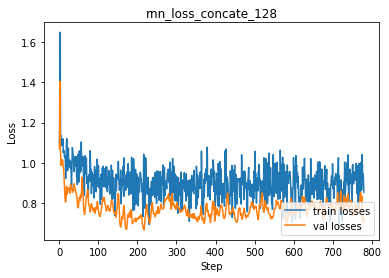

In [46]:
# RNN_CONCATE_128
# plot for losses
title = 'rnn_loss_concate_128'
plt.plot(train_losses_1, label='train losses')
plt.plot(val_losses_1, label='val losses')
plt.legend(loc='lower right')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title(title)
plt.savefig(title + ".png")

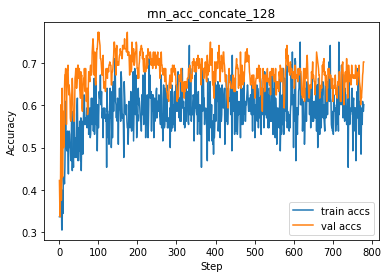

In [47]:
# RNN_CONCATE_128
# plot for accs
title = 'rnn_acc_concate_128'
plt.plot(train_accs_1, label='train accs')
plt.plot(val_accs_1, label='val accs')
plt.legend(loc='lower right')
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title(title)
plt.savefig(title + ".png")

In [128]:
print(max(train_accs_1))

0.75


In [49]:
print(max(val_accs_1))

0.7734375


In [139]:
# RNN_CONCATE_256
# get number of trainable parameters
model_parameters_2 = filter(lambda p: p.requires_grad, model.parameters())
params_2 = sum([np.prod(p.size()) for p in model_parameters_2])

In [140]:
print("Number of trainable parameters are {}.".format(params_2))

Number of trainable parameters are 6394671.


In [141]:
train_losses_2, train_accs_2, val_losses_2, val_accs_2 = train_losses, train_accs, val_losses, val_accs

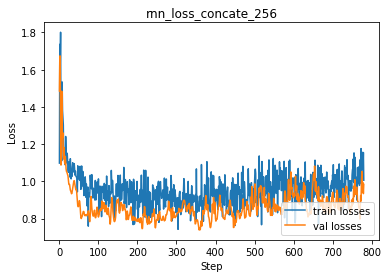

In [132]:
# RNN_CONCATE_256
# plot for losses
title = 'rnn_loss_concate_256'
plt.plot(train_losses_2, label='train losses')
plt.plot(val_losses_2, label='val losses')
plt.legend(loc='lower right')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title(title)
plt.savefig(title + ".png")

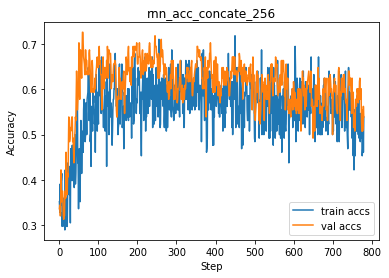

In [133]:
# RNN_CONCATE_256
# plot for accs
title = 'rnn_acc_concate_256'
plt.plot(train_accs_2, label='train accs')
plt.plot(val_accs_2, label='val accs')
plt.legend(loc='lower right')
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title(title)
plt.savefig(title + ".png")

In [134]:
print(max(train_accs_2))

0.71875


In [135]:
print(max(val_accs_2))

0.7265625


In [142]:
# RNN_CONCATE_64
# get number of trainable parameters
model_parameters_3 = filter(lambda p: p.requires_grad, model.parameters())
params_3 = sum([np.prod(p.size()) for p in model_parameters_3])

In [143]:
print("Number of trainable parameters are {}.".format(params_3))

Number of trainable parameters are 6394671.


In [144]:
train_losses_3, train_accs_3, val_losses_3, val_accs_3 = train_losses, train_accs, val_losses, val_accs

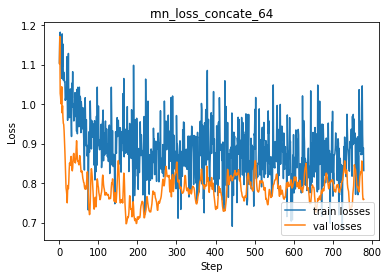

In [145]:
# RNN_CONCATE_64
# plot for losses
title = 'rnn_loss_concate_64'
plt.plot(train_losses_3, label='train losses')
plt.plot(val_losses_3, label='val losses')
plt.legend(loc='lower right')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title(title)
plt.savefig(title + ".png")

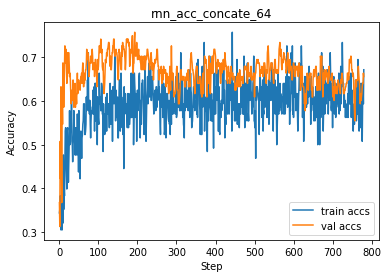

In [146]:
# RNN_CONCATE_64
# plot for accs
title = 'rnn_acc_concate_64'
plt.plot(train_accs_3, label='train accs')
plt.plot(val_accs_3, label='val accs')
plt.legend(loc='lower right')
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title(title)
plt.savefig(title + ".png")

In [147]:
print(max(train_accs_3))

0.7578125


In [148]:
print(max(val_accs_3))

0.7578125


In [177]:
# RNN_MULTI_128
# get number of trainable parameters
model_parameters_4 = filter(lambda p: p.requires_grad, model.parameters())
params_4 = sum([np.prod(p.size()) for p in model_parameters_4])

In [178]:
print("Number of trainable parameters are {}.".format(params_4))

Number of trainable parameters are 6489519.


In [179]:
train_losses_4, train_accs_4, val_losses_4, val_accs_4 = train_losses, train_accs, val_losses, val_accs

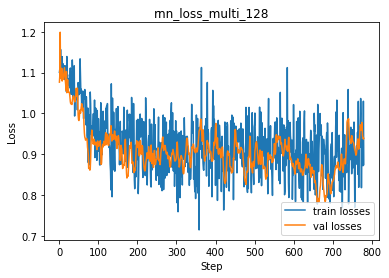

In [180]:
# RNN_MULTI_128
# plot for losses
title = 'rnn_loss_multi_128'
plt.plot(train_losses_4, label='train losses')
plt.plot(val_losses_4, label='val losses')
plt.legend(loc='lower right')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title(title)
plt.savefig(title + ".png")

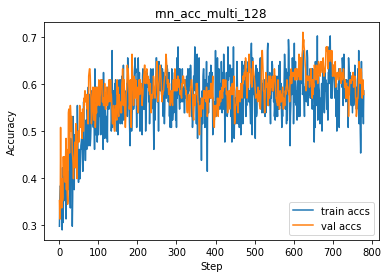

In [181]:
# RNN_MULTI_128
# plot for accs
title = 'rnn_acc_multi_128'
plt.plot(train_accs_4, label='train accs')
plt.plot(val_accs_4, label='val accs')
plt.legend(loc='lower right')
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title(title)
plt.savefig(title + ".png")

In [182]:
print(max(train_accs_4))

0.703125


In [183]:
print(max(val_accs_4))

0.7109375


### Process Multi-NLI Validation Dataset to Evaluate RNNs

In [191]:
nli = pd.read_csv("./hw2_data/mnli_val.tsv", sep='\t', header=0)

In [192]:
nli["genre"].unique()

array(['fiction', 'telephone', 'slate', 'government', 'travel'],
      dtype=object)

In [193]:
def load_data_2(PATH_TO_FILE, genre):
    data = pd.read_csv(PATH_TO_FILE, sep='\t', header=0)
    s1_text = []
    s2_text = []
    label = []
    for idx, row in data.iterrows():
        s1 = row['sentence1'].lower()
        s2 = row['sentence2'].lower()
        g = row['genre'].lower()
        if g == genre:
            label.append(label_idx[row['label'].lower()])
            s1_text.append(s1.split())
            s2_text.append(s2.split())
    return s1_text, s2_text, label

In [194]:
fiction_s1_text, fiction_s2_text, fiction_label = load_data_2("./hw2_data/mnli_val.tsv", 'fiction')

In [195]:
tele_s1_text, tele_s2_text, tele_label = load_data_2("./hw2_data/mnli_val.tsv", 'telephone')

In [196]:
slate_s1_text, slate_s2_text, slate_label = load_data_2("./hw2_data/mnli_val.tsv", 'slate')

In [197]:
gov_s1_text, gov_s2_text, gov_label = load_data_2("./hw2_data/mnli_val.tsv", 'government')

In [198]:
travel_s1_text, travel_s2_text, travel_label = load_data_2("./hw2_data/mnli_val.tsv", 'travel')

In [199]:
tele_s1_indices = token2index_dataset(tele_s1_text)
tele_s2_indices = token2index_dataset(tele_s2_text)

In [200]:
slate_s1_indices = token2index_dataset(slate_s1_text)
slate_s2_indices = token2index_dataset(slate_s2_text)

In [201]:
gov_s1_indices = token2index_dataset(gov_s1_text)
gov_s2_indices = token2index_dataset(gov_s2_text)

In [202]:
travel_s1_indices = token2index_dataset(travel_s1_text)
travel_s2_indices = token2index_dataset(travel_s2_text)

In [203]:
fiction_s1_indices = token2index_dataset(fiction_s1_text)
fiction_s2_indices = token2index_dataset(fiction_s2_text)

In [236]:
def padding(input1, input2, labels):
    s1_data_list = []
    s2_data_list = []
    for i in range(len(input1)):
        if len(input1[i]) == MAX_SENTENCE_LENGTH:
            s1_data_list.append(np.asarray(input1[i]))
        elif len(input1[i]) < MAX_SENTENCE_LENGTH:
            s1_padded_vec = np.pad(np.array(input1[i]),
                                pad_width=(0,(MAX_SENTENCE_LENGTH-len(input1[i]))),
                                mode="constant", constant_values=0)
            s1_data_list.append(s1_padded_vec)
        else :
            s1_data_list.append(np.asarray(input1[:MAX_SENTENCE_LENGTH]))
            
        if len(input2[i]) == MAX_SENTENCE_LENGTH:
            s2_data_list.append(np.asarray(input2[i]))
        elif len(input2[i]) < MAX_SENTENCE_LENGTH:
            s2_padded_vec = np.pad(np.array(input2[i]),
                                pad_width=(0,(MAX_SENTENCE_LENGTH-len(input2[i]))),
                                mode="constant", constant_values=0)
            s2_data_list.append(np.asarray(s2_padded_vec))
        else :
            s2_data_list.append(input2[:MAX_SENTENCE_LENGTH])
    return [torch.from_numpy(np.array(s1_data_list)), torch.from_numpy(np.array(s2_data_list)), torch.LongTensor(label_list)]

In [ ]:
fiction_s1, fiction_s2, fiction_l = padding(fiction_s1_text, fiction_s1_text, fiction_label)

In [205]:
def evaluate2(model, sent1, sent2, sent1_len, sent2_len, labels):
    logits = model(sent1, sent2, sent1_len, sent2_len)
    _, pred = torch.max(logits, 1)
    acc = (labels == pred).sum()
    pred_value = pred.cpu().data
    acc_value = acc.cpu().data.numpy() / labels.size()[0]
    return float(acc_value)

In [ ]:
print(evaluate2(model, ))